# Extracting historical climate (rainfall) data over selected basins

* **Products used:** 
ERA5

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.load_era5 import load_era5


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Analysis Parameters

## Retrieve historical rainfall data over all areas of interest

This data has already been retrieved from ERA5 so we can simply pull in the csv on disk

In [2]:
upstream_rainfall = 'results/upstream_rainfall_daily_1989-01_to_2009-12.csv'
upstream_rainfall = pd.read_csv(upstream_rainfall, index_col='time',parse_dates=True)
upstream_rainfall.head()

,cumulative daily rainfall (mm)
time,
1989-01-01,3.232178
1989-01-02,4.107727
1989-01-03,2.748047
1989-01-04,0.680115
1989-01-05,0.550232


#### Code block that loads rainfall from ERA5

In [ ]:
# # Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f
# vector_file = 'data/OB_FWR_Hydrography_Okavango_Subasins_polygon.geojson'

# # define time period of interest
# time_range = '1989-01', '2009-12'

# # load basin polygons
# # Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f-caee3d756da9
# basin = gpd.read_file(vector_file)

# # upstream include Cuito and Cubango subbasins
# upstream = basin[basin.Subbasin.isin(['Cuito', 'Cubango'])]
# print(upstream)

# # get historical rainfall for upstream and delta
# bounds = upstream.total_bounds
# lat = bounds[1], bounds[3]
# lon = bounds[0], bounds[2]

# # download ERA5 rainfall and aggregate to monthly
# var = 'precipitation_amount_1hour_Accumulation'
# precip = load_era5(var, lat, lon, time_range, reduce_func=np.sum, resample='1D').compute()

# # fix inconsistency in axis names
# precip = precip.rename({'lat':'latitude', 'lon':'longitude'})

# upstream_raster = xr_rasterize(upstream, precip, x_dim='longitude', y_dim='latitude')

# upstream_rainfall = precip[var].where(upstream_raster).sum(['latitude','longitude'])

# upstream_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'precipitation_amount_1hour_Accumulation':'cumulative daily rainfall (mm)'},axis=1).to_csv(f'results/upstream_rainfall_daily_{time_range[0]}_to_{time_range[1]}.csv')

### Plot daily rainfall

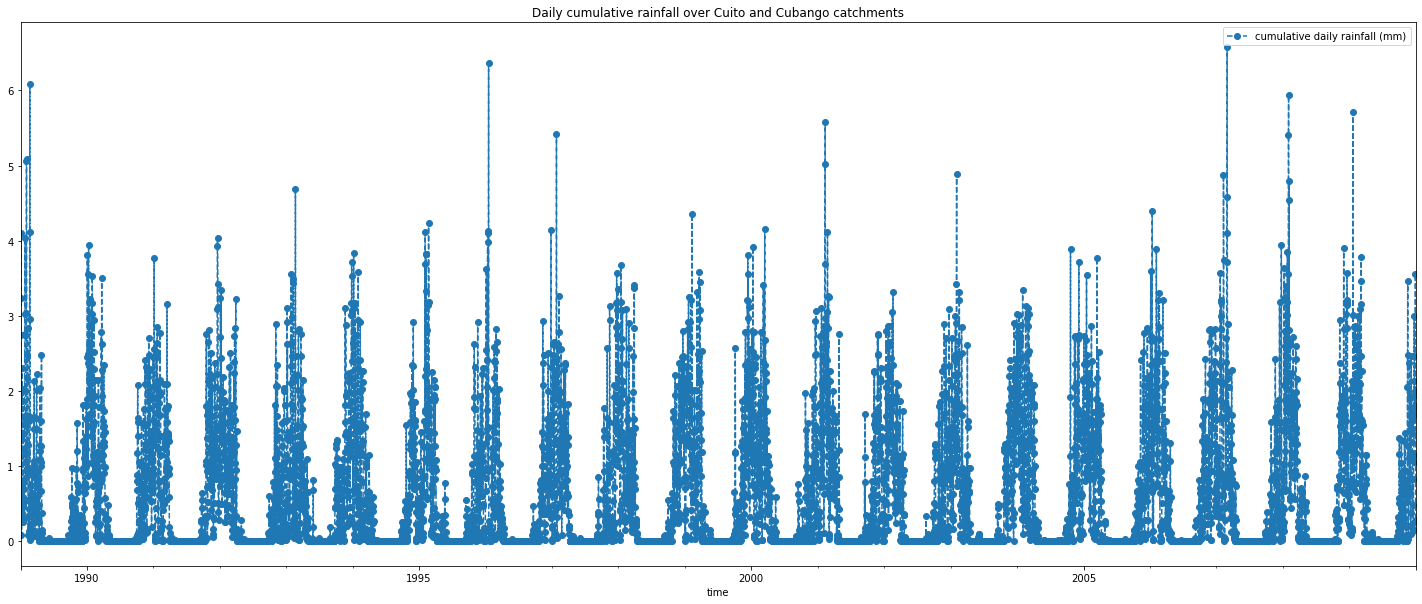

In [3]:
upstream_rainfall.plot(figsize=(25,10), marker='o', linestyle='dashed')
plt.title('Daily cumulative rainfall over Cuito and Cubango catchments');

## Import discharge data

In [4]:
discharge = 'data/mohembo_daily_water_discharge_data.csv'
dis=pd.read_csv(discharge)
dis['date'] = pd.to_datetime(dis['date'], dayfirst=True)
dis = dis.set_index('date')

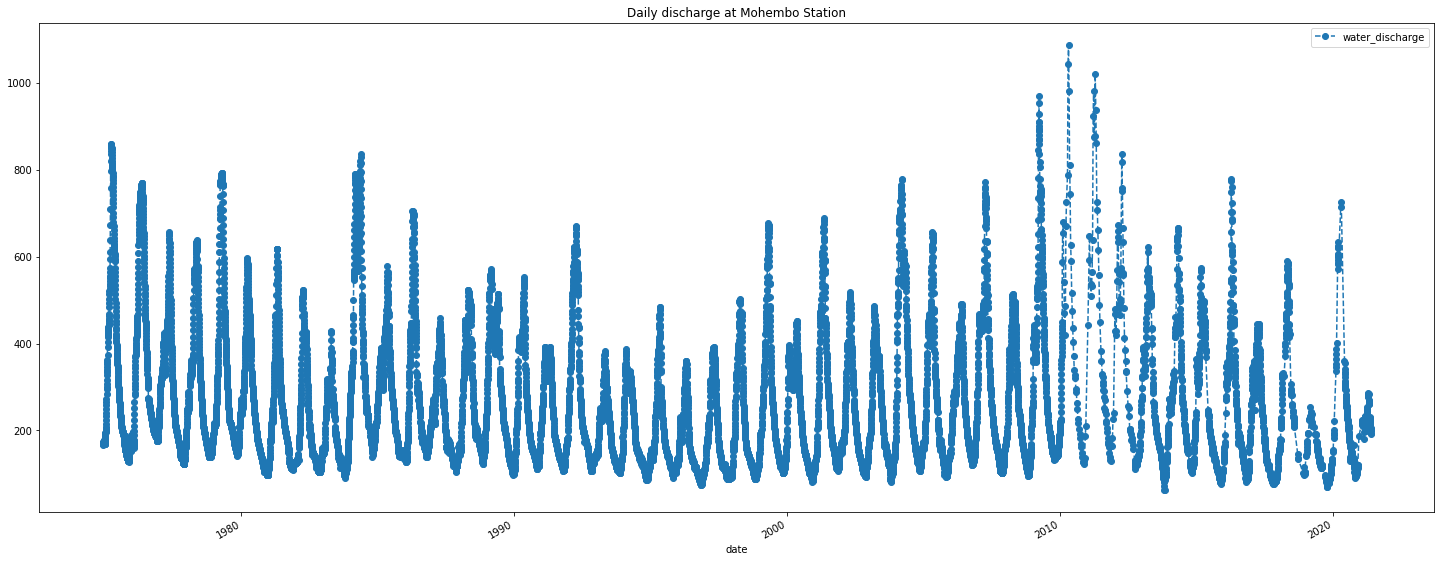

In [5]:
dis.plot(figsize=(25,10),  marker='o', linestyle='dashed')
plt.title('Daily discharge at Mohembo Station');

## Modelling rainfall and discharge at Mohembo

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [7]:
max_lags = 6

### Match discharge with rainfall


In [8]:
df = upstream_rainfall.join(dis, how='inner')
df.head()

,cumulative daily rainfall (mm),water_discharge
1989-01-01,3.232178,265.93
1989-01-02,4.107727,274.26
1989-01-03,2.748047,286.54
1989-01-04,0.680115,295.05
1989-01-05,0.550232,305.53


### Resample to monthly cumulative totals

This will help with identifying the best time lag

In [9]:
freq='M'

In [10]:
#total rainfall per month
df = df.resample(freq).sum()
df.head()

,cumulative daily rainfall (mm),water_discharge
1989-01-31,45.216431,11713.97
1989-02-28,46.583008,15470.90
1989-03-31,22.774780,14089.42
1989-04-30,22.132874,12032.10
1989-05-31,0.052734,14698.84


### Explore correlations with lags in rainfall

Correlations at each lag: [0.013, 0.48, 0.777, 0.821, 0.666, 0.33]


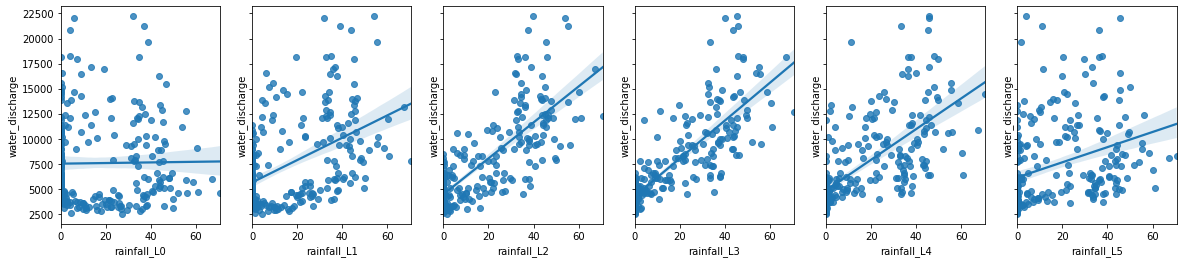

In [13]:
def crosscorr(datay, datax, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datay.corr(datax.shift(lag))

xcov = [crosscorr(df['water_discharge'], df['cumulative daily rainfall (mm)'], lag=i) for i in range(max_lags)]
print('Correlations at each lag:', [round(i,3) for i in xcov])

fig, ax = plt.subplots(1,max_lags, figsize=(20,4), sharey=True)
for lag in range(max_lags):
    xcovlag = np.argmax(xcov)
    df['rainfall_L'+str(lag)] = df['cumulative daily rainfall (mm)'].shift(lag)
    sns.regplot(x='rainfall_L'+str(lag), y='water_discharge', data=df, ax=ax[lag]);
    

### Linear modelling

Conduct a test/train split first to get an idea of its accuracy 

In [16]:
max_value = max(xcov)
best_lag = xcov.index(max_value)

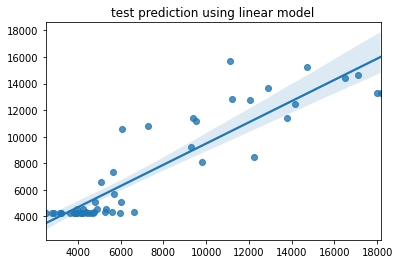

In [17]:
X = df['rainfall_L3'][best_lag:].values.reshape(-1,1)
y = df['water_discharge'][best_lag:].values.reshape(-1,1)

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

sns.regplot(x=y_test, y=y_pred)
plt.title('test prediction using linear model');

### Predict Discharge at Mohembo

#### Import rainfall from the period we want to predict

In [18]:
fc_rainfall = 'results/upstream_rainfall_daily_2010-01_to_2021-05-26.csv'
fc_rainfall = pd.read_csv(fc_rainfall, index_col='time',parse_dates=True)
fc_rainfall=fc_rainfall.resample(freq).sum()
fc_rainfall=fc_rainfall.shift(3)
X_fc = fc_rainfall[3:].values.reshape(-1,1)

#### Make a prediction using rainfall data

In [19]:
model = LinearRegression()
model.fit(X,y)
fc = model.predict(X_fc)

#### Resample discharge data and clip to time when discharge data is incomplete (>2010)

In [20]:
dis_m = dis.resample('M').sum()
dis_m_2010 = dis_m[(dis_m.index >= pd.to_datetime('2010-01-01'))]

#### Plot predictions vs observed

These likely won't match well because we know the oberved dicharge data is incomplete (hence the modelling)

<AxesSubplot:xlabel='water_discharge'>

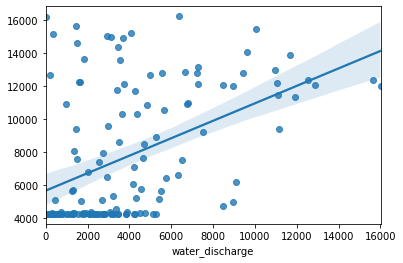

In [21]:
sns.regplot(x=dis_m_2010[3:], y=fc)

## Plot the observed vs predicted discharge

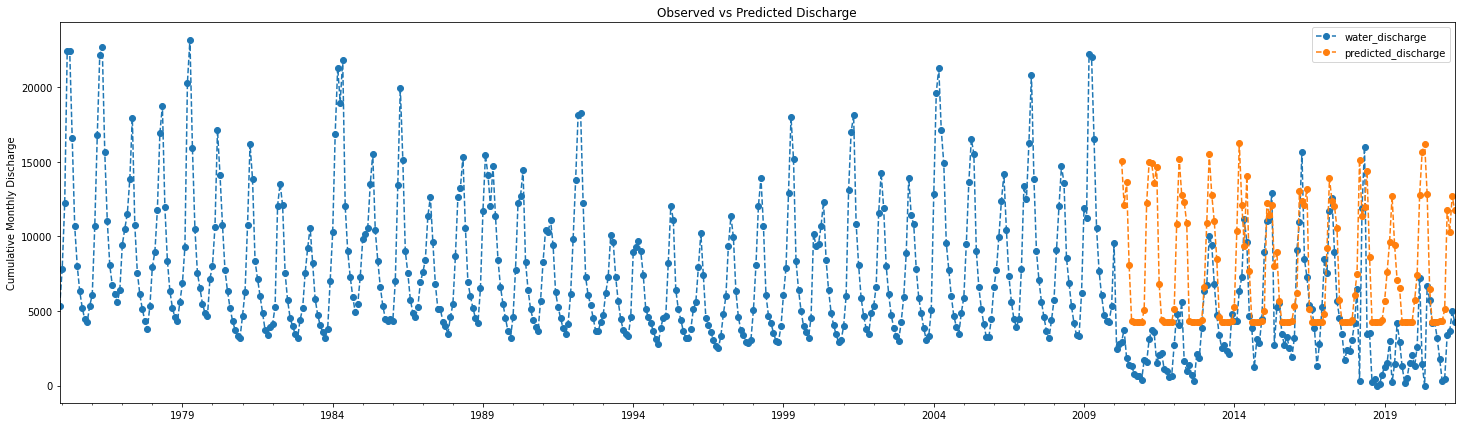

In [25]:
df_predicted = pd.DataFrame({'observed_discharge':dis_m_2010[3:].values.reshape(-1), 'predicted_discharge':fc.reshape(-1)}, index=dis_m_2010[3:].index)
dis_m.join(df_predicted['predicted_discharge'], how='outer').plot(figsize=(25,7), marker='o', linestyle='dashed')
plt.title('Observed vs Predicted Discharge')
plt.ylabel('Cumulative Monthly Discharge')
plt.xlabel('');


In [33]:
fc_rainfall

,cumulative daily rainfall (mm)
time,
2010-01-31,NaN
2010-02-28,NaN
2010-03-31,NaN
2010-04-30,57.166382
2010-05-31,41.642701
...,...
2021-01-31,4.426941
2021-02-28,39.890564
2021-03-31,32.055847


In [32]:
df_predicted.join

,observed_discharge,predicted_discharge
date,,
2010-04-30,2918.018,15058.082797
2010-05-31,3753.407,12126.591425
2010-06-30,1830.872,13657.400664
2010-07-31,1358.363,8105.870016
2010-08-31,1323.475,4312.623318
...,...,...
2021-01-31,446.578,5098.768784
2021-02-28,3396.437,11795.718018
2021-03-31,3648.041,10316.210348


In [31]:
df['rainfall_L3']

1989-01-31          NaN
1989-02-28          NaN
1989-03-31          NaN
1989-04-30    45.216431
1989-05-31    46.583008
                ...    
2009-08-31     0.455078
2009-09-30     0.050537
2009-10-31     0.000122
2009-11-30     0.000000
2009-12-31     1.598511
Freq: M, Name: rainfall_L3, Length: 252, dtype: float64

In [ ]:
model = LinearRegression()
model.fit(X,y)
fc = model.predict(X_fc)

#### Plot zoomed in on > 2010 

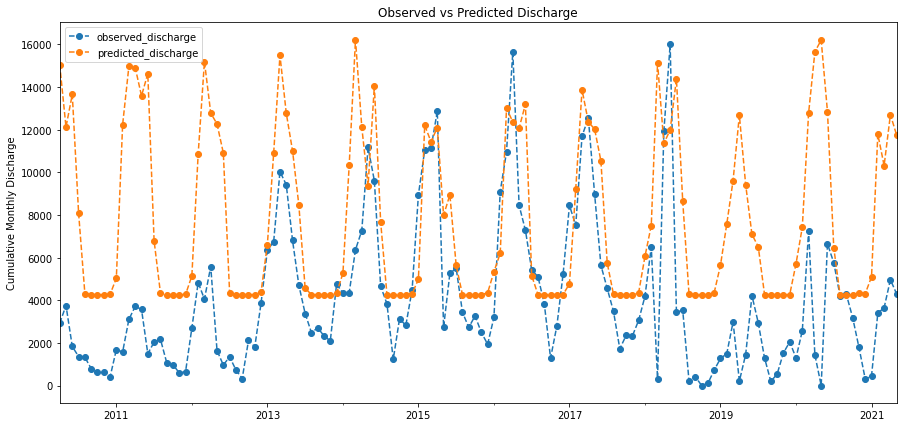

In [27]:
fig,ax = plt.subplots(1,1, figsize=(15,7))
df_predicted.plot(ax=ax, marker='o', linestyle='dashed')
plt.title('Observed vs Predicted Discharge')
plt.ylabel('Cumulative Monthly Discharge')
plt.xlabel('');

---
## Try an ARIMA model

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [ ]:
p=6
d=1
q=0

In [ ]:
model = ARIMA(endog=df['water_discharge'], exog=df['cumulative daily rainfall (mm)'], order=(p, d, q))
fit = model.fit()
# fit.summary()

### Plot the residuals of the model

In [ ]:
residuals = pd.DataFrame(fit.resid)
print(residuals.describe())
fig, ax = plt.subplots(1,2, figsize=(12,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

### Hindcast

In [ ]:
start=0
end=len(df)-1

hc = fit.predict(start=start, end=end, exog=df['cumulative daily rainfall (mm)'], dynamic=False)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(15,7))
hc.plot(ax=ax, label='Hindcast')
df['water_discharge'].plot(ax=ax, label='observed')
plt.title('Monthly discharge at Mohembo: hindcast vs observed')
ax.legend();

In [ ]:
from statsmodels.tsa.stattools import acf

In [ ]:
test_len = int(len(df)*0.25)

In [ ]:
df[test_len:]

In [ ]:
# Create Training and Test
train = df.value[:85]
test = df.value[85:]

### Forecast

In [ ]:
fc_len = 120

#### Load the rainfall data from the forecast period

In [ ]:
fc_rainfall = 'results/upstream_rainfall_daily_2010-01_to_2021-05-26.csv'
fc_rainfall = pd.read_csv(fc_rainfall, index_col='time',parse_dates=True)
fc_rainfall=fc_rainfall.resample(freq).sum()

In [ ]:
dis_m = dis.resample('M').sum()
dis_m = dis_m[(dis_m.index >= pd.to_datetime('2010-01-01'))]

In [ ]:
fc = fit.forecast(steps=fc_len, exog=fc_rainfall['cumulative daily rainfall (mm)'][:fc_len])

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(15,7))
fc.plot(ax=ax, label='Forecast')
dis_m.plot(ax=ax, label='observed')
plt.title('Monthly discharge at Mohembo: Forecast vs observed')
ax.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')